In [2]:
from power_planner.utils import shift_surface, get_donut_vals, get_half_donut, get_distance_surface
from power_planner.plotting import plot_path, plot_path_costs
import numpy as np
from graph_tool.all import Graph, shortest_path,load_graph, find_edge
import time
from collections import deque
import matplotlib.pyplot as plt
import os
import json
import pickle

# Pipeline:
- work on full instance only, and only edit pos2node
- start: full instance, only consider every fith node
- entweder mit downsampling, oder mit randomly deleting edges
- probability should depend on distance from path, and on cost
- randomly delete half of the edges, find new path --> add to best path


- reset graph methode?
- vary hard constraints?

Ideen:
- take min instead of mean --> searching for optimal path with minimum values

In [3]:
instance_path = "/Users/ninawiedemann/Downloads/tifs_new/data_dump_2.dat"
with open(instance_path, "rb") as infile:
    (instance, instance_corr, start_inds, dest_inds) = pickle.load(infile)

In [4]:
LAYER_CLASSES = ['cultural', 'human', 'planning', 'technical']
CLASS_WEIGHT = [0.28571429, 0.35714286, 0.14285714, 0.21428571]
PYLON_DIST_MIN = 7.5
PYLON_DIST_MAX = 12.5
vec = [-69, 216]
MAX_ANGLE = 0.5 * np.pi

In [32]:
graph = WeightedGraph(
        instance, instance_corr, graphtool=1, verbose=1
    )

initialized weighted graph (pos2node and node_pos)


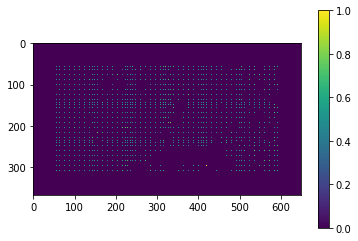

In [33]:
plt.imshow(graph.cost_rest[2])
plt.colorbar()
plt.show()

### explicitely add start and dest

In [34]:
graph.cost_rest[:, dest_inds[0], dest_inds[1]] = instance[:, dest_inds[0], dest_inds[1]]
graph.cost_rest[:, start_inds[0], start_inds[1]] = instance[:, start_inds[0], start_inds[1]]

In [35]:
graph.set_edge_costs(LAYER_CLASSES, CLASS_WEIGHT)
graph.set_shift(PYLON_DIST_MIN, PYLON_DIST_MAX, vec, MAX_ANGLE)
# add nodes and vertices
graph.add_nodes()
graph.add_edges()
# weighted sum of all costs
graph.sum_costs()
source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
print("start and end:", source_v, target_v)

['cultural', 'human', 'planning', 'technical'] [0.28571429 0.35714286 0.14285714 0.21428571]
Added nodes: 112971 in time: 0.0048940181732177734
DONE adding 948019 edges: 2.62921404838562
start and end: 175935 64197


In [45]:
path, path_costs = graph.get_shortest_path(source_v, target_v)

In [39]:
paths = graph.get_pareto(np.arange(0, 1.1, 0.1), source_v, target_v, compare=[2, 3])

In [38]:
print(len(list(graph.graph.vertices())), len(list(graph.graph.edges())))

203732 948019


In [134]:
len(list(graph.graph.edges()))# removed edges --> only 1.3 mio instead of 4 mio

1359485

In [40]:
dist_surface = get_distance_surface(graph.pos2node.shape, paths, mode="dilation")

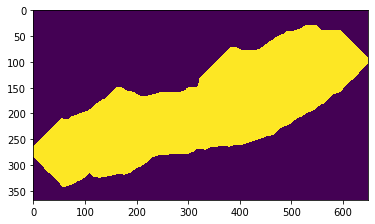

In [135]:
plt.imshow(dist_surface>30)
plt.show()

In [ ]:
# only change cost_rest, not pos2node
# use max instead of mean --> replacing the edge is always improving it
# use find_edge to determine edges with high cost?

out costs shape: (51, 4)
instance shape (4, 368, 649)


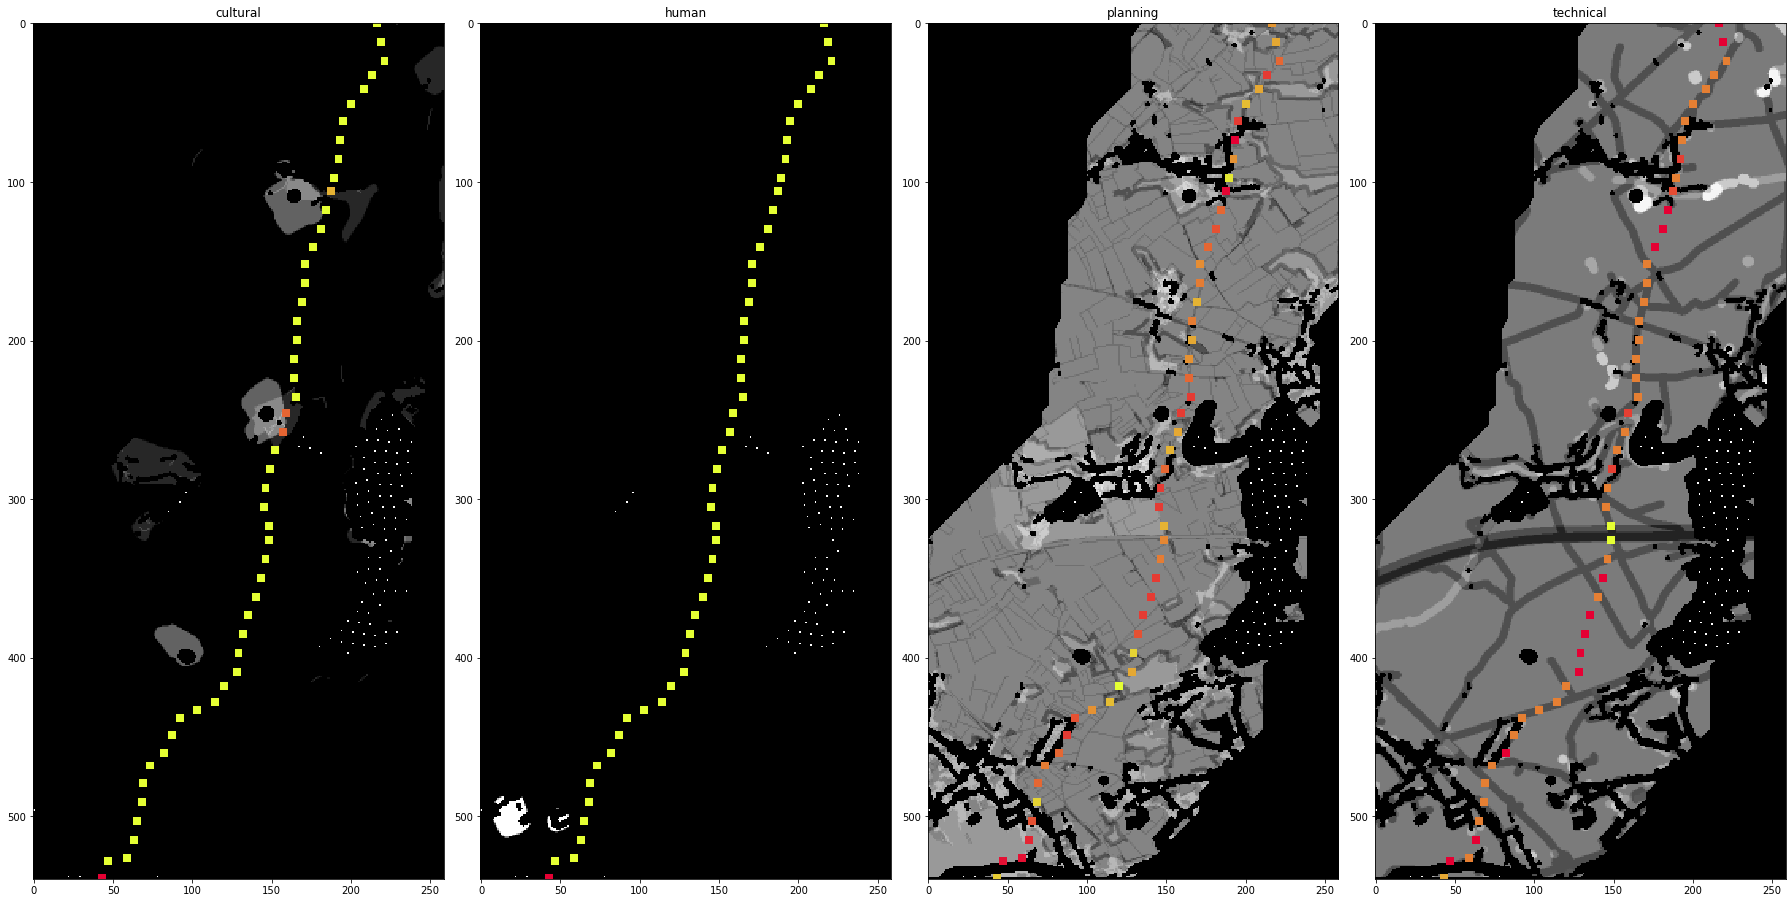

In [46]:
plot_path_costs(graph.cost_rest,
    path,
    path_costs,
    graph.cost_classes,
    buffer=2)

out costs shape: (55, 4)
instance shape (4, 368, 649)


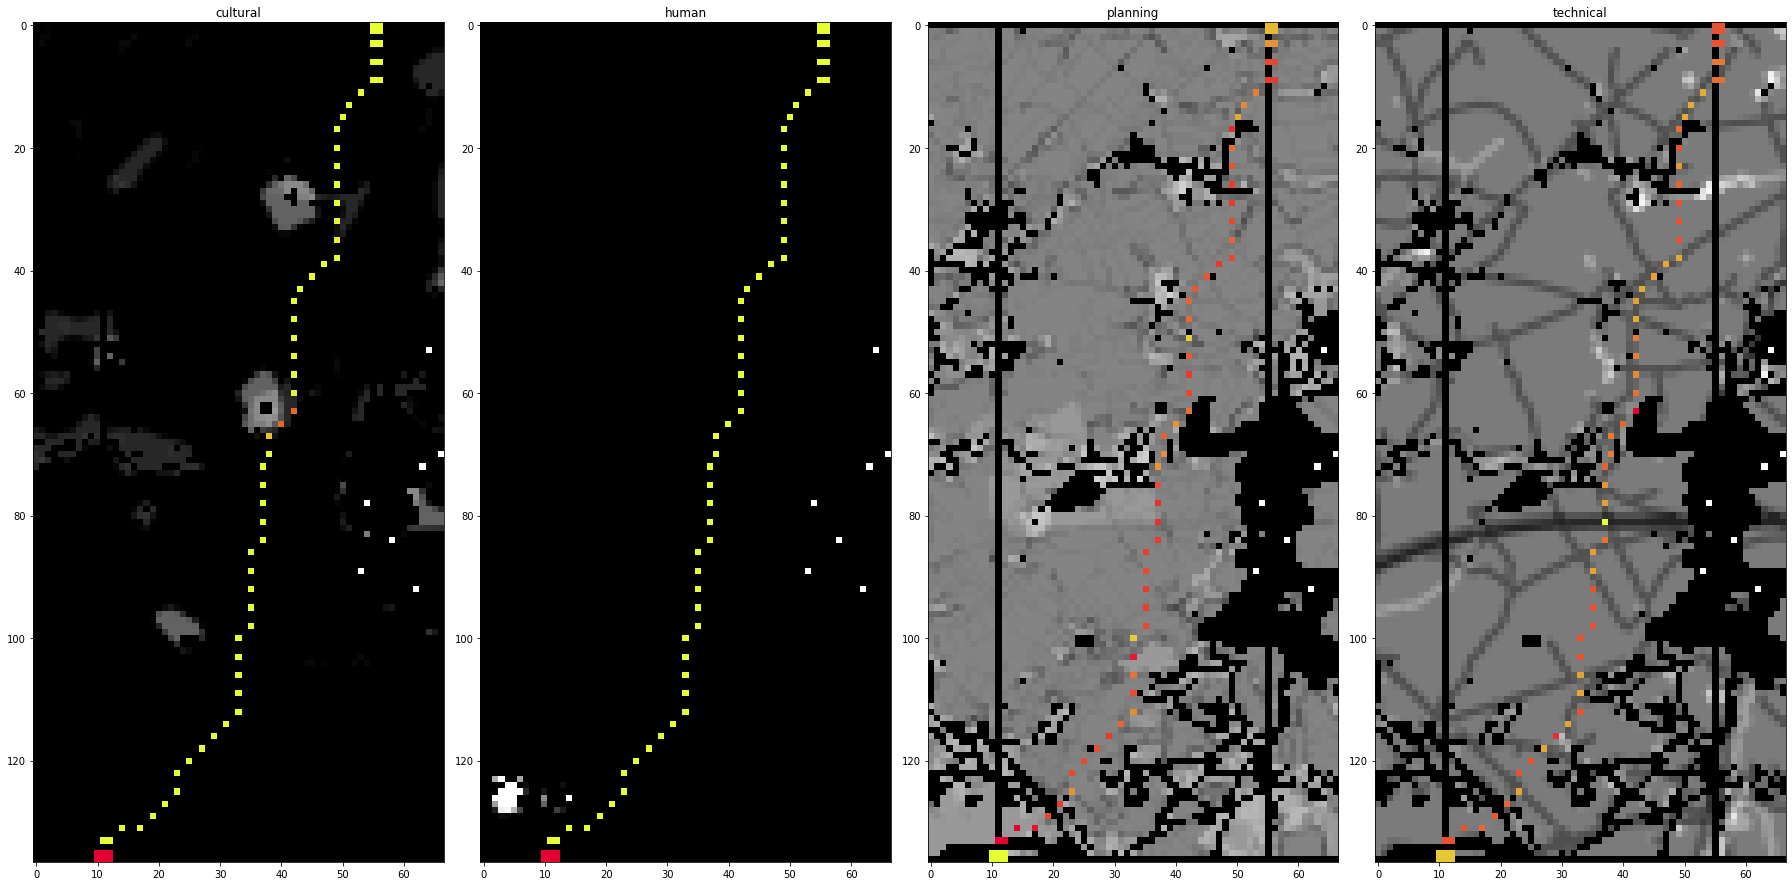

In [37]:
plot_path_costs(graph.cost_rest,
    path,
    path_costs,
    graph.cost_classes,
    buffer=2)

## Graph Code

In [41]:
graph.remove_vertices((dist_surface>30).astype(int))
graph.update_cost_rest((dist_surface>15).astype(int))

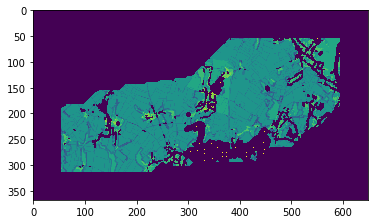

In [42]:
plt.imshow(graph.cost_rest[2])
plt.show()

In [43]:
graph.add_edges()

DONE adding 10652034 edges: 6.9997498989105225


In [44]:
graph.sum_costs()

In [31]:
import numpy as np
from graph_tool.all import Graph, shortest_path, load_graph, find_edge
import time
import networkx as nx
from power_planner.utils import get_half_donut
from power_planner.plotting import plot_pareto


class GeneralGraph():

    def __init__(self, graphtool=1, directed=True, verbose=1):
        if graphtool:
            self.graph = Graph(directed=directed)
            self.weight = self.graph.new_edge_property("float")
        else:
            if directed:
                print("directed graph")
                self.graph = nx.DiGraph()
            else:
                self.graph = nx.Graph()
        self.time_logs = {}
        self.verbose = verbose
        self.graphtool = graphtool

    def set_edge_costs(self, classes, weights=None):
        if weights is None:
            weights = [1 for i in range(len(classes))]
        weights = np.array(weights)
        # set different costs:
        self.cost_classes = classes
        self.cost_props = [
            self.graph.new_edge_property("float") for _ in range(len(classes))
        ]
        self.cost_weights = weights / np.sum(weights)
        print(self.cost_classes, self.cost_weights)

    def set_shift(self, lower, upper, vec, max_angle):
        self.shifts = get_half_donut(lower, upper, vec, angle_max=max_angle)

    def add_nodes(self, nodes):
        """
        param nodes: list of node names if networkx, integer if graphtool
        """
        tic = time.time()
        # add nodes to graph
        if self.graphtool:
            _ = self.graph.add_vertex(nodes)
        else:
            self.graph.add_nodes_from(np.arange(nodes))
        # verbose
        if self.verbose:
            print("Added nodes:", nodes, "in time:", time.time() - tic)
        self.time_logs["add_nodes"] = round(time.time() - tic, 3)

    def sum_costs(self):
        # add sum of all costs
        tic = time.time()
        summed_costs_arr = np.zeros(self.cost_props[0].get_array().shape)
        for i in range(len(self.cost_props)):
            prop = self.cost_props[i].get_array()
            summed_costs_arr += prop * self.cost_weights[i]
        self.weight.a = summed_costs_arr

        self.time_logs["sum_of_costs"] = round(time.time() - tic, 3)

    def get_pareto(self, vary, source, dest, out_path=None, compare=[0, 1]):
        """
        compute shortest paths with varied weights
        """
        pareto = list()
        paths = list()
        cost0 = self.cost_props[compare[0]].get_array()
        cost1 = self.cost_props[compare[1]].get_array()
        class0 = self.cost_classes[compare[0]]
        class1 = self.cost_classes[compare[1]]
        # test_edge = find_edge(self.graph, self.graph.edge_index, 44)[0]
        for w in vary:
            self.weight.a = cost0 * w + cost1 * (1 - w)
            # print("test weight", self.weight[test_edge])
            path, path_costs = self.get_shortest_path(source, dest)
            # print(
            #     class0, "weight:", w, class1, "weight:", 1 - w, "costs:",
            #     np.mean(path_costs, axis=0)
            # )
            pareto.append(np.sum(path_costs, axis=0))
            paths.append(path)
        # PLOTTING:
        # pareto = np.asarray(pareto)
        # pareto0 = pareto[:, compare[0]]
        # pareto1 = pareto[:, compare[1]]
        # plot_pareto(
        #     pareto0, pareto1, paths, vary, [class0, class1], out_path=out_path
        # )
        # plot_pareto_paths(paths, [class0, class1], out_path=out_path)
        return paths

    def get_shortest_path(self, source, target):
        """
        Compute shortest path from source vertex to target vertex
        """
        tic = (time.time())
        # #if source and target are given as indices:
        if self.graphtool:
            vertices_path, _ = shortest_path(
                self.graph,
                source,
                target,
                weights=self.weight,
                negative_weights=True
            )
        else:
            vertices_path = nx.dijkstra_path(self.graph, source, target)

        self.time_logs["shortest_path"] = round(time.time() - tic, 3)
        return vertices_path

    def save_graph(self, OUT_PATH):
        if self.graphtool:
            for i, cost_class in enumerate(self.cost_classes):
                self.graph.edge_properties[cost_class] = self.cost_props[i]
            self.graph.edge_properties["weight"] = self.weight
            self.graph.save(OUT_PATH + ".xml.gz")
        else:
            nx.write_weighted_edgelist(
                self.graph, OUT_PATH + '.weighted.edgelist'
            )

    def load_graph(self, IN_PATH):
        if self.graphtool:
            self.g_prev = load_graph(IN_PATH + ".xml.gz")
            self.weight_prev = self.g_prev.ep.weight
            # weight = G2.ep.weight[G2.edge(66, 69)]
        else:
            self.g_prev = nx.read_edgelist(
                IN_PATH + '.weighted.edgelist',
                nodetype=int,
                data=(('weight', float), )
            )
                

class WeightedGraph(GeneralGraph):

    def __init__(
        self,
        cost_instance,
        hard_constraints,
        directed=True,
        graphtool=1,
        verbose=1
    ):
        # assert cost_instance.shape == hard_constraints.shape
        # , "Cost size must be equal to corridor definition size!"

        # time logs
        self.time_logs = {}
        tic = time.time()

        # indicator whether to use networkx or graph tool
        self.graphtool = graphtool

        # cost surface
        self.cost_instance = cost_instance
        self.hard_constraints = hard_constraints
        self.x_len, self.y_len = hard_constraints.shape

        # initialize graph:
        GeneralGraph.__init__(
            self, directed=directed, graphtool=graphtool, verbose=verbose
        )

        self.cost_rest = self.cost_instance * (self.hard_constraints >
                                               0).astype(int)
        # print statements
        self.verbose = verbose

        self.time_logs["init_graph"] = round(time.time() - tic, 3)
        
        _, self.cost_rest = self.set_pos2node(self.cost_rest, 4) # self.pos2node,
        
        self.pos2node = np.arange(1, self.x_len*self.y_len+1).reshape((self.x_len, self.y_len))
        print("initialized weighted graph (pos2node and node_pos)")
        self.pos2node *= (self.hard_constraints > 0).astype(int)
        self.pos2node[self.pos2node==0] = -1
        
        self.cost_rest *= (self.hard_constraints > 0).astype(int)
        self.mean_cost_rest = np.mean(self.cost_rest, axis=0)
        
    def set_pos2node(self, img, factor):
        x_len_new = img.shape[1] // factor
        y_len_new = img.shape[2] // factor
        pos2node = np.zeros((img.shape[1], img.shape[2]))
        new_img = np.zeros(img.shape)
        pos2node += -1
        lab = 0
        for i in range(x_len_new):
            for j in range(y_len_new):
                patch = img[:, i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
                if np.any(patch):
                    pos2node[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor] = lab
                    lab += 1
                # x_cost = int(mean([i * factor, (i + 1) * factor])
                    for k in range(len(new_img)):
                        part = patch[k]
                        if np.any(part):
                            new_img[k, i*factor, j*factor] = np.mean(part[part>0])
        return pos2node, new_img

    def set_shift(self, lower, upper, vec, max_angle):
        GeneralGraph.set_shift(self, lower, upper, vec, max_angle)
        self.shift_vals = get_donut_vals(self.shifts, vec)

    def add_nodes(self):
        tic = time.time()
        # add nodes to graph
        n_nodes = len(np.unique(self.pos2node))
        GeneralGraph.add_nodes(self, n_nodes)
        self.time_logs["add_nodes"] = round(time.time() - tic, 3)

    def _update_time_logs(
        self, times_add_edges, times_edge_list, tic_function
    ):
        self.time_logs["add_edges"] = round(np.mean(times_add_edges), 3)
        self.time_logs["add_edges_times"] = times_add_edges

        self.time_logs["edge_list"] = round(np.mean(times_edge_list), 3)
        self.time_logs["edge_list_times"] = times_edge_list

        self.time_logs["add_all_edges"] = round(time.time() - tic_function, 3)

    def _compute_edge_costs(self, shift_index):
        # switch axes for shift
        cost_rest_switched = np.moveaxis(self.cost_rest, 0, -1)
        # shift by shift
        costs_shifted = shift_surface(
            cost_rest_switched, self.shifts[shift_index]
        )
        # switch axes back
        costs_shifted = np.moveaxis(costs_shifted, -1, 0)

        weights = (costs_shifted + self.cost_rest) / 2
        # new version: edge weights
        # weights = convolve_faster(self.cost_rest, kernels[i], posneg[i])
        # weights = weights1 + 2 * weights2
        # print(
        #     "max node weights", np.max(weights1), "max edge weights:",
        #     np.max(weights2), "min node weights", np.min(weights1),
        #     "min edge weights:", np.min(weights2)
        # )

        inds_shifted = self.pos2node[np.mean(costs_shifted,axis=0) > 0]
        # delete the ones where inds_shifted is zero

        # take weights of the shifted ones
        weights_arr = np.array(
            [w[costs_shifted[i] > 0] for i, w in enumerate(weights)]
        )

        return inds_shifted, weights_arr

    def add_edges(self):
        tic_function = time.time()
        inds_orig = self.pos2node[np.mean(self.cost_rest,axis=0) > 0]
        
        n_edges = 0
        # kernels, posneg = get_kernel(self.shifts, self.shift_vals)
        # edge_array = []

        times_edge_list = []
        times_add_edges = []

        for i in range(len(self.shifts)):

            tic_edges = time.time()

            # compute shift and weights
            inds_shifted, weights_arr = self._compute_edge_costs(i)
            assert len(inds_shifted) == len(
                inds_orig
            ), "orig:{},shifted:{}".format(len(inds_orig), len(inds_shifted))

            # concatenete indices and weights, select feasible ones
            inds_arr = np.asarray([inds_orig, inds_shifted])
            inds_weights = np.concatenate((inds_arr, weights_arr), axis=0)
            pos_inds = inds_shifted >= 0
            out = np.swapaxes(inds_weights, 1, 0)[pos_inds]

            # remove edges with high costs:
            # first two columns of out are indices
            # weights_arr = np.mean(out[:, 2:], axis=1)
            # weights_mean = np.quantile(weights_arr, 0.9)
            # inds_higher = np.where(weights_arr < weights_mean)
            # out = out[inds_higher[0]]

            n_edges += len(out)
            times_edge_list.append(round(time.time() - tic_edges, 3))

            # add edges to graph
            tic_graph = time.time()
            if self.graphtool:
                self.graph.add_edge_list(out, eprops=self.cost_props)
            else:
                nx_edge_list = [(e[0], e[1], {"weight": e[2]}) for e in out]
                self.graph.add_edges_from(nx_edge_list)
            times_add_edges.append(round(time.time() - tic_graph, 3))

            # alternative: collect edges here and add alltogether
            # edge_array.append(out)

        self._update_time_logs(times_add_edges, times_edge_list, tic_function)
        if self.verbose:
            print("DONE adding", n_edges, "edges:", time.time() - tic_function)
            
    def remove_vertices(self, corridor):
        corr_vertices = self.pos2node * corridor
        new_vertices = corr_vertices[corr_vertices>0]
        for v in new_vertices:
            self.graph.clear_vertex(self.graph.vertex(v))
            
    def update_cost_rest(self, corridor):
        self.cost_rest = self.cost_instance * self.hard_constraints * corridor
        self.mean_cost_rest = np.mean(self.cost_rest, axis=0)
        inverted_corridor = np.absolute(1-corridor).astype(bool)
        self.pos2node[inverted_corridor] = -1

    def add_start_and_dest(self, start_inds, dest_inds):
        start_node_ind = self.pos2node[start_inds[0], start_inds[1]]
        dest_node_ind = self.pos2node[dest_inds[0], dest_inds[1]]
        if self.graphtool:
            return self.graph.vertex(start_node_ind
                                     ), self.graph.vertex(dest_node_ind)
        else:
            return start_node_ind, dest_node_ind

    
    def get_shortest_path(self, source, target):
        tic = time.time()

        # compute shortest path
        vertices_path, _ = shortest_path(
            self.graph,
            source,
            target,
            weights=self.weight,
            negative_weights=True
        )
        # else:
        #     vertices_path = nx.dijkstra_path(self.graph, source, target)

        # transform path
        path = []
        out_costs = []
        for v in vertices_path:
            v_ind = self.graph.vertex_index[v]
            x_inds, y_inds = np.where(self.pos2node == v_ind)
            # find minimum value field out of possible
            
            min_ind_x = int(np.mean(x_inds))
            min_ind_y = int(np.mean(y_inds))

            path.append((min_ind_x, min_ind_y))
            out_costs.append(self.cost_rest[:, min_ind_x, min_ind_y].tolist())
        
        self.time_logs["shortest_path"] = round(time.time() - tic, 3)

        return path, out_costs
    

### Tests:

In [ ]:
# TEST THAT EDGES ARE NOT OVERWRITTEN - MULTIGRAPH
g = Graph()
w = g.new_edge_property("float")
edges = []
for i in range(20):
    edges.append([i,i+1,i])
g.add_edge_list(edges, eprops=[w])
# e = find_edge(g, g.edge_index, 13)

new_edges = []
for i in range(15,20):
    new_edges.append([i,i+1,i-5])
g.add_edge_list(new_edges, eprops=[w])

e = g.add_edge(g.vertex(13), g.vertex(14))
w[e] = 10

for e in g.edges():
    print(e)
    print(w[e])